# PART 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

# Import the Porter stemmer
from nltk.stem.porter import *

from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\phuon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\phuon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\phuon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### a. Initial cleaning
For later usage, skip this part and go to part b

In [7]:
# SKIP THIS PART IF DON'T WANT TO WAIT FOR THE DATA TO LOAD
tw_data = pd.read_csv('Twitter_Jan_Mar.csv')
tw_data.head()

,date,id,content,username,like_count,retweet_count
0,2023-03-29 22:58:21+00:00,1641213230730051584,"Free AI marketing and automation tools, strate...",RealProfitPros,0.0,0.0
1,2023-03-29 22:58:18+00:00,1641213218520481805,@MecoleHardman4 Chat GPT says it’s 15. 😂,AmyLouWho321,0.0,0.0
2,2023-03-29 22:57:53+00:00,1641213115684536323,https://t.co/FjJSprt0te - Chat with any PDF!\n...,yjleon1976,0.0,0.0
3,2023-03-29 22:57:52+00:00,1641213110915571715,"AI muses: ""In the court of life, we must all f...",ChatGPT_Thinks,0.0,0.0
4,2023-03-29 22:57:26+00:00,1641213003260633088,Most people haven't heard of Chat GPT yet.\nFi...,nikocosmonaut,0.0,0.0


In [3]:
tw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500036 entries, 0 to 500035
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           500036 non-null  object 
 1   id             500030 non-null  object 
 2   content        500030 non-null  object 
 3   username       500002 non-null  object 
 4   like_count     499974 non-null  float64
 5   retweet_count  499974 non-null  float64
dtypes: float64(2), object(4)
memory usage: 22.9+ MB


In [8]:
# drop missing labels
tw_data = tw_data.dropna()

# remove unused columns
tw_data = tw_data.drop(columns=['id', 'username', 'retweet_count'])

# check if there is any missing data left
tw_data.isnull().sum()

date          0
content       0
like_count    0
dtype: int64

In [11]:
# Code copied from part 1 but made some changes on names/values

# Create a new column in our DF that contains token lists instead of raw text
def tokenize_text(df):
  df['tokens'] =  df["content"].apply(lambda x: x.split())

# Remove any URL tokens
def remove_url(df):
  df['tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if not re.match(r'http\S+', word)])

# NEW: Remove any additional tokens related to chatgpt
def remove_chatgpt(df):
  chatgpt_terms = {'chat', 'chat gpt', 'chatgpt', 'gpt', 'gpt-4', 'gpt4', 'gpt3', 'openai'}

  df['tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word.lower() not in chatgpt_terms and 
                                                    not re.match(r'^[@#]\S+', word)])


# Remove all punctuation (,.?!;:’") and special characters(@, #, +, &, =, $, etc). Also, convert all tokens to lowercase only. 
def add_cleaned_tokens(df):
    cleaned_tokens = []
    for row in df['tokens']:
      cleaned_tokens.append([re.sub(r'[^a-zA-Z0-9]', '', t).lower() for t in row if re.sub(r'[^a-zA-Z0-9]', '', t)])
    df['cleaned_tokens'] = cleaned_tokens

# Stemm tokens by the Porter stememr
def stem_tokens(df):
  stemmer = PorterStemmer()
  df['stemmed_tokens'] = df['cleaned_tokens'].apply(lambda tokens: [stemmer.stem(t) for t in tokens])

# Remove stopwords in english
def remove_stopwords(df):
  sw = stopwords.words('english')
  tokens_no_sw = []
  for row in df['stemmed_tokens']:
    tokens_no_sw.append([t for t in row if t not in sw])
  df['tokens_no_sw'] = tokens_no_sw


In [12]:
# Process the data by going through all the steps from tokenization -> remove special characters -> stemming -> stopwords
def process_data(df):
  tokenize_text(df)
  remove_url(df)
  remove_chatgpt(df)
  add_cleaned_tokens(df)
  stem_tokens(df)
  remove_stopwords(df)
  return df

tw_data = process_data(tw_data)

tw_data.head()

,date,content,like_count,tokens,cleaned_tokens,stemmed_tokens,tokens_no_sw
0,2023-03-29 22:58:21+00:00,"Free AI marketing and automation tools, strate...",0.0,"[Free, AI, marketing, and, automation, tools,,...","[free, ai, marketing, and, automation, tools, ...","[free, ai, market, and, autom, tool, strategi,...","[free, ai, market, autom, tool, strategi, coll..."
1,2023-03-29 22:58:18+00:00,@MecoleHardman4 Chat GPT says it’s 15. 😂,0.0,"[says, it’s, 15., 😂]","[says, its, 15]","[say, it, 15]","[say, 15]"
2,2023-03-29 22:57:53+00:00,https://t.co/FjJSprt0te - Chat with any PDF!\n...,0.0,"[-, with, any, PDF!, Check, out, how, this, ne...","[with, any, pdf, check, out, how, this, new, a...","[with, ani, pdf, check, out, how, thi, new, ai...","[ani, pdf, check, thi, new, ai, quickli, answe..."
3,2023-03-29 22:57:52+00:00,"AI muses: ""In the court of life, we must all f...",0.0,"[AI, muses:, ""In, the, court, of, life,, we, m...","[ai, muses, in, the, court, of, life, we, must...","[ai, muse, in, the, court, of, life, we, must,...","[ai, muse, court, life, must, face, judg, dest..."
4,2023-03-29 22:57:26+00:00,Most people haven't heard of Chat GPT yet.\nFi...,0.0,"[Most, people, haven't, heard, of, yet., First...","[most, people, havent, heard, of, yet, first, ...","[most, peopl, havent, heard, of, yet, first, e...","[peopl, havent, heard, yet, first, elit, facti..."


In [13]:
# clear unused column, renamed the final cleaned column
tw_data['cleaned_content'] = tw_data['tokens_no_sw']
tw_data = tw_data.drop(columns=['tokens', 'cleaned_tokens', 'stemmed_tokens', 'tokens_no_sw'])

# convert to a csv file so that we don't have to run and wait raw data again
tw_data.to_csv("twitter_cleaned.csv", index = False)

### b. Vectorization and Clustering

In [14]:
# Run this instead of part (a) for future attempts
tw_data = pd.read_csv('twitter_cleaned.csv')
tw_data

,date,content,like_count,cleaned_content
0,2023-03-29 22:58:21+00:00,"Free AI marketing and automation tools, strate...",0.0,"['free', 'ai', 'market', 'autom', 'tool', 'str..."
1,2023-03-29 22:58:18+00:00,@MecoleHardman4 Chat GPT says it’s 15. 😂,0.0,"['say', '15']"
2,2023-03-29 22:57:53+00:00,https://t.co/FjJSprt0te - Chat with any PDF!\n...,0.0,"['ani', 'pdf', 'check', 'thi', 'new', 'ai', 'q..."
3,2023-03-29 22:57:52+00:00,"AI muses: ""In the court of life, we must all f...",0.0,"['ai', 'muse', 'court', 'life', 'must', 'face'..."
4,2023-03-29 22:57:26+00:00,Most people haven't heard of Chat GPT yet.\nFi...,0.0,"['peopl', 'havent', 'heard', 'yet', 'first', '..."
...,...,...,...,...
499969,2023-01-04 07:18:08+00:00,@GoogleAI #LAMDA Versus @OpenAI #ChatGPT ?! Wh...,1.0,"['versu', 'care', 'lamda', 'isnt', 'avail', 'r..."
499970,2023-01-04 07:17:50+00:00,#ChatGPT \n\nSo much #Censorship.\n\nNever tru...,2.0,"['much', 'never', 'trust', 'system', 'dont', '..."
499971,2023-01-04 07:17:20+00:00,all my twitter feed is about ChatGPT and @Open...,3.0,"['twitter', 'feed', 'lol']"
499972,2023-01-04 07:17:08+00:00,I'm quite amazed by Chat GPT. A really promisi...,1.0,"['im', 'quit', 'amaz', 'gpt', 'realli', 'promi..."


In [19]:
from sklearn.feature_extraction.text import CountVectorizer

def override_fcn(doc):
  # We expect a list of tokens as input
  return doc

# Count Vectorizer
def count_vectorizer(df):
  X_df = df['cleaned_content'].to_numpy()
  vocab_count = X_df.shape[0]

  print(f"The length of vocabulary is: {vocab_count}")

  count_vec = CountVectorizer(
    analyzer='word',
    tokenizer= override_fcn,
    preprocessor= None,
    token_pattern= None,
    max_features = vocab_count)

  counts = count_vec.fit_transform(X_df)

  print(f"vec: {counts.toarray()}")
  print(f"vec shape: {counts.shape}")
  return counts

In [22]:
vec = count_vectorizer(tw_data)

The length of vocabulary is: 499974
vec: [[ 9 20  9 ...  0  0  0]
 [ 1  4  1 ...  0  1  0]
 [14 30 14 ...  0  0  0]
 ...
 [ 2  6  2 ...  0  0  0]
 [ 9 20  9 ...  0  0  1]
 [ 9 20  9 ...  0  1  0]]
vec shape: (499974, 41)


In [ ]:
# # Vectorizing using TF-IDF vectors
# from sklearn.feature_extraction.text import TfidfVectorizer

# # TF-IDF Vectorizer
# vectorizer = TfidfVectorizer(lowercase=True,
#                                 #max_features=100,
#                                 # max_df=0.99,
#                                 # min_df=1,
#                                 ngram_range = (1,3),
#                                 stop_words = "english"
#                             )

# # fit the model to the tweet data
# vectors = vectorizer.fit_transform(tw_data)

# vectors.shape

(4, 4)

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()

# TF-IDF Vectorizer
def tfidf_vectorizer(counts):
    tfidf_data = tfidf.fit_transform(counts)
    print(f"TF-IDF vec shape: {tfidf_data.shape}")

    return tfidf_data

In [23]:
# Apply TF-IDF Vectorizer to the train and test data
tfidf_data = tfidf_vectorizer(vec)

TF-IDF vec shape: (499974, 41)


In [24]:
tfidf_data

<499974x41 sparse matrix of type '<class 'numpy.float64'>'
	with 10825494 stored elements in Compressed Sparse Row format>

Yiwei Tried something

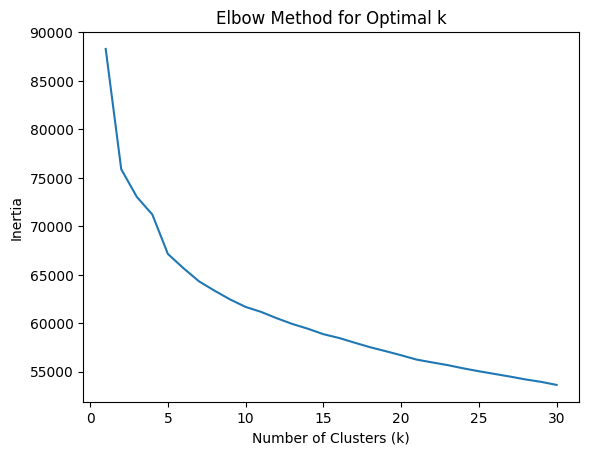

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def plot_elbow_method(tfidf_data):
    # Using Elbow Method to find the optimal k
    inertia = []
    for k in range(1, 31):  
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(tfidf_data)
        inertia.append(kmeans.inertia_)
    
    # Plotting the Elbow graph
    plt.plot(range(1, 31), inertia)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.show()

# Plot Elbow method
plot_elbow_method(tfidf_data)

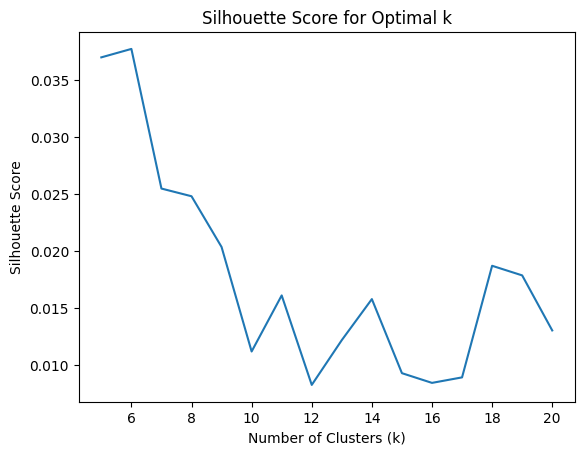

In [26]:
from sklearn.utils import resample
def plot_silhouette_score(tfidf_data):
    silhouette_scores = []
    k_values = range(5, 21)
    
    for k in k_values:
        sampled_data = resample(tfidf_data, n_samples=5000, random_state=42)
        kmeans = KMeans(n_clusters=k, n_init = 2, init="random", max_iter = 300, random_state=42)
        kmeans.fit(sampled_data)
        score = silhouette_score(sampled_data, kmeans.labels_)
        silhouette_scores.append(score)
    
    # Plot Silhouette scores
    plt.plot(range(5, 21), silhouette_scores)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Optimal k')
    plt.show()

# Plot Silhouette score
plot_silhouette_score(tfidf_data)

In [ ]:
optimal_k = 11
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(tfidf_data)

tw_data['cluster'] = kmeans.labels_

print(tw_data[['cleaned_content', 'cluster']].head())

                                     cleaned_content  cluster
0  ['free', 'ai', 'market', 'autom', 'tool', 'str...        4
1                                      ['say', '15']        1
2  ['ani', 'pdf', 'check', 'thi', 'new', 'ai', 'q...        9
3  ['ai', 'muse', 'court', 'life', 'must', 'face'...        5
4  ['peopl', 'havent', 'heard', 'yet', 'first', '...        9


In [31]:
import re

# Custom tokenizer function using regex
def custom_tokenizer(text):
    # Keep only alphabetic characters and split by spaces
    return re.findall(r'\b[a-zA-Z]+\b', text.lower())

# Using TfidfVectorizer with the custom tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

def tfidf_vectorizer(df):
    X_df = df['cleaned_content'].to_numpy()

    # Initialize the TfidfVectorizer with the custom tokenizer
    tfidf_vec = TfidfVectorizer(analyzer='word', tokenizer=custom_tokenizer, stop_words='english')

    # Fit and transform the data into the TF-IDF matrix
    tfidf_data = tfidf_vec.fit_transform(X_df)

    # Get feature names to see the actual terms
    feature_names = tfidf_vec.get_feature_names_out()
    #print("Vocabulary (first 10 words):", feature_names[:10])  # Print the first 10 terms

    return tfidf_data, feature_names

# Test the TF-IDF vectorizer with a small sample of the data
tfidf_data, feature_names = tfidf_vectorizer(tw_data)

# Now we can apply KMeans to cluster the data and see which terms are important for each cluster

# Let's fit KMeans clustering on the TF-IDF data
n_clusters = 11
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(tfidf_data)

# Function to print top terms per cluster
def print_top_terms_per_cluster(kmeans, terms, top_n=20):

    for i in range(kmeans.n_clusters):
        print(f"Cluster {i}:")
        cluster_centroid = kmeans.cluster_centers_[i]
        top_indices = cluster_centroid.argsort()[-top_n:][::-1]  # Get indices of top terms
        top_terms = [terms[index] for index in top_indices]
        print("Top terms:", ", ".join(top_terms))
        print()
    return text

# Print the top terms for each cluster
cluster_text = print_top_terms_per_cluster(kmeans, feature_names)

c:\Users\phuon\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Cluster 0:
Top terms: free, base, trial, trade, signal, pm, chart, await, kmhr, humid, sunris, temp, sunset, wind, ai, statu, c, buy, speed, instruct

Cluster 1:
Top terms: ask, write, question, thi, wa, gpt, poem, use, ai, like, respons, think, make, im, result, whi, said, tri, got, help

Cluster 2:
Top terms: problem, solv, thi, use, solut, ai, code, ha, help, math, like, ask, think, wa, write, peopl, tri, question, work, make

Cluster 3:
Top terms: ai, tool, gener, new, like, use, futur, human, chatgpt, chatbot, ha, amp, power, technolog, content, creat, world, make, job, replac

Cluster 4:
Top terms: model, languag, larg, ai, gener, natur, use, new, chatgpt, power, process, openai, text, train, like, ha, thi, learn, develop, understand

Cluster 5:
Top terms: answer, question, ask, thi, use, wa, wrong, ai, like, ha, chatgpt, search, think, good, provid, right, time, tri, correct, gave

Cluster 6:
Top terms: googl, bard, search, ai, microsoft, bing, rival, engin, vs, chatbot, chatgpt

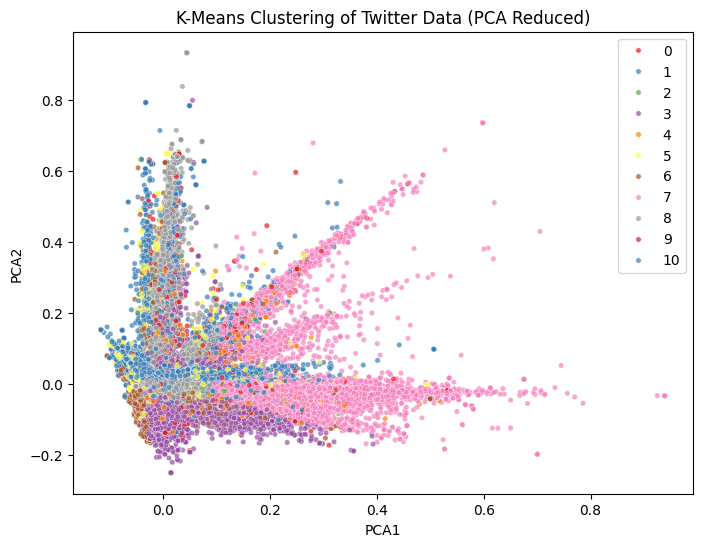

In [33]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Perform PCA to reduce dimensionality to 2D (work directly with sparse matrix)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(tfidf_data)  # No need to convert to array

# Create a DataFrame with PCA results and cluster labels
pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = kmeans.labels_

# Visualize the clusters in 2D space with additional enhancements
plt.figure(figsize=(8, 6))

# Plot the clusters with different colors
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='cluster', palette='Set1', s=15, alpha=0.7)

# Plot the centroids of each cluster in the PCA space
# centroids = pca.transform(kmeans.cluster_centers_)  # Transform centroids to 2D PCA space
# plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label='Centroids')

# Add labels to the points (optional, can be commented out for clarity)
# for i in range(len(pca_df)):
#     plt.text(pca_df.PCA1[i], pca_df.PCA2[i], str(i), fontsize=9)

plt.title('K-Means Clustering of Twitter Data (PCA Reduced)')
plt.legend(loc='best')
plt.show()


In [5]:
import ast
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

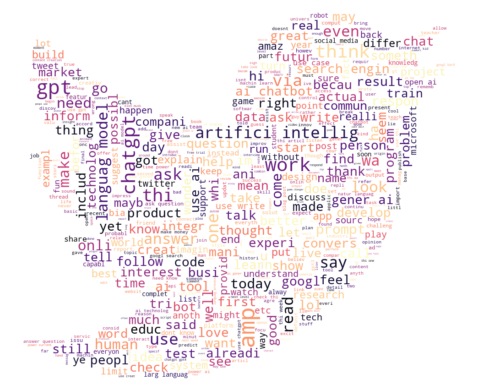

In [17]:
twitter_mask = np.array(Image.open('./Twitter.png'))

# text = "".join(str(content).strip("") for content in tw_data['cleaned_content'])
text = " ".join(" ".join(ast.literal_eval(content)) for content in tw_data['cleaned_content'])
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white",contour_color = 'white', colormap = 'magma', mask = twitter_mask).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [49]:
def print_top_terms_per_cluster(kmeans, terms, top_n=50):
    cluster_word_data = {}

    for i in range(kmeans.n_clusters):
        print(f"Cluster {i}:")
        cluster_centroid = kmeans.cluster_centers_[i]
        top_indices = cluster_centroid.argsort()[-top_n:][::-1]  # Get indices of top terms
        top_terms = {terms[index]: cluster_centroid[index] for index in top_indices}
        
        # Store in dictionary
        cluster_word_data[i] = top_terms

        print("Top terms:", ", ".join(top_terms.keys()))
        print()

    return cluster_word_data

# Generate word cloud for a specific cluster
def plot_wordcloud(word_data, cluster_id):
    if cluster_id not in word_data:
        print(f"Cluster {cluster_id} not found.")
        return
    
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_data[cluster_id])

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Cluster {cluster_id}")
    plt.show()
cluster_word_data = print_top_terms_per_cluster(kmeans, feature_names)

Cluster 0:
Top terms: chat, chatgpt, new, ha, know, make, time, work, amp, wa, think, prompt, need, tri, power, help, gener, learn, futur, world, human, creat, join, way, read, good, thank, day, whi, model, intellig, im, today, thing, dont, better, doe, look, job, peopl, free, talk, let, market, onli, user, chang, microsoft, great, best

Cluster 1:
Top terms: use, chat, creat, way, make, tool, ai, gener, learn, chatgpt, case, help, content, work, peopl, know, prompt, code, student, time, start, im, api, new, model, ha, busi, dont, amp, tri, think, languag, market, develop, thi, need, free, idea, wa, product, want, video, ive, great, good, best, app, build, gpt, research

Cluster 2:
Top terms: thi, chat, use, ai, wa, check, think, ha, new, know, time, make, articl, week, learn, work, thing, read, im, chatgpt, help, gener, tri, technolog, way, dont, need, amp, look, good, tool, model, year, whi, creat, peopl, tweet, prompt, video, want, realli, post, thank, let, thread, talk, love, answe

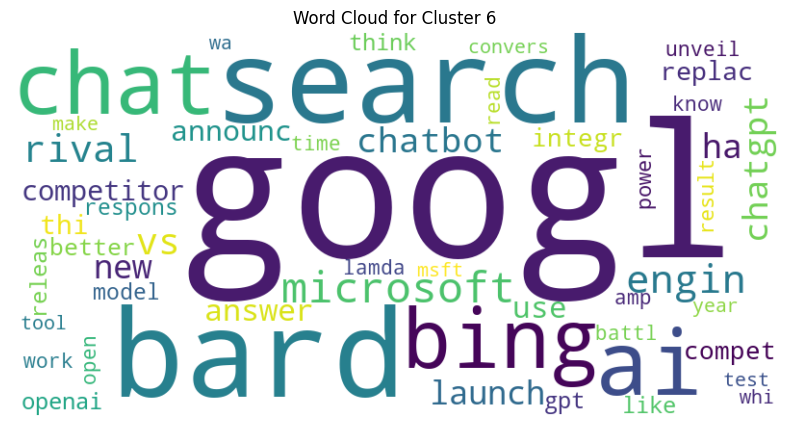

In [50]:
plot_wordcloud(cluster_word_data, cluster_id=6)  # Change cluster_id to visualize other clusters